# Importer Library, Dataset et Modèle

In [204]:
import joblib
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import shap

shap.initjs()
sys.path.append('/workspace')

In [50]:
# import model
model = joblib.load("../results/models/recall_90_spec_10/rf_classweight_na.pkl")
model.named_steps

{'column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('scalar', StandardScaler(),
                                  ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                   'AMT_GOODS_PRICE',
                                   'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                   'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                   'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
                                   'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
                                   'REGION_RATING_CLIENT_W_CITY',
                                   'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1',
                                   'EXT_SOURCE_2', 'EXT_SOURCE_3',
                                   'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
                                   'YEARS_BEGINEXPLUATATION_AVG',
                                  

In [80]:
%%time
# import DataFrames
X_test = pd.read_csv("../data/train/X_test.csv")
print("Test dataset:", X_test.shape)

Test dataset: (101472, 795)
CPU times: user 24 s, sys: 56.6 s, total: 1min 20s
Wall time: 1min 20s


In [133]:
X_test_3000 = X_test[:3000]
X_test_3000.to_csv("../data/train/X_test_3000.csv", index=False)

In [53]:
%%time
X_test_transformed = model[:-1].transform(X_test_3000)

CPU times: user 351 ms, sys: 520 µs, total: 351 ms
Wall time: 283 ms


In [81]:
feature_names = X_test.columns
importances = pd.Series(
    model[-1].feature_importances_, index=feature_names
).sort_values(ascending=False)
importance_top_20 = importances[:20]

In [83]:
importance_top_20.index

Index(['FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMP_PHONE', 'AMT_ANNUITY',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_GOODS_PRICE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'FLAG_DOCUMENT_5', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN', 'COMMONAREA_MEDI',
       'LIVINGAREA_MEDI', 'FLAG_DOCUMENT_4', 'AMT_INCOME_TOTAL',
       'ORGANIZATION_TYPE_Advertising', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'NAME_HOUSING_TYPE_Office apartment',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY'],
      dtype='object')

In [111]:
importance_top_20.to_csv("../data/train/feature_importance.csv")

# Gauge Chart

In [6]:
# get random client number
sample_idx = random.randint(0, len(X_test_transformed))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


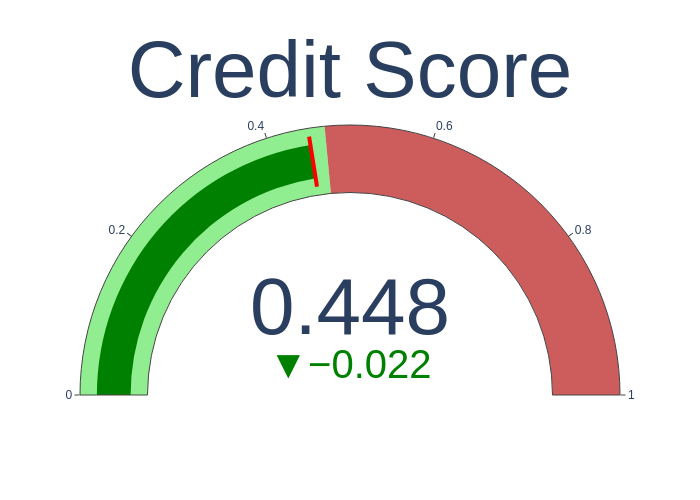

CPU times: user 77.2 ms, sys: 31.3 ms, total: 108 ms
Wall time: 139 ms


In [29]:
%%time
# predict credit score
score = model[-1].predict_proba(X_test_transformed[sample_idx].reshape(1, -1))[0, 1]
# plot gauge chart
fig = go.Figure(
    go.Indicator(
        domain={"x": [0, 1], "y": [0, 1]},
        value=score,
        mode="gauge+number+delta",
        title={"text": "Credit Score", "font": {"size": 80}},
        delta={
            "reference": 0.47,
            "increasing": {"color": "indianred"},
            "decreasing": {"color": "green"},
        },
        gauge={
            "axis": {"range": [None, 1]},
            "steps": [
                {"range": [0, 0.47], "color": "lightgreen"},
                {"range": [0.47, 1], "color": "indianred"},
            ],
            "threshold": {
                "line": {"color": "red", "width": 4},
                "thickness": 0.75,
                "value": 0.45,
            },
        },
    )
)

fig.show("png")

# Local Features Importance - SHAP

## Transformer le Dataset avec les 100 Plus Importantes Features

In [5]:
%%time
# get shap explainer
explainer = shap.TreeExplainer(model.named_steps['model'], X_test_transformed)

CPU times: user 52.4 ms, sys: 2.07 ms, total: 54.5 ms
Wall time: 52.4 ms


In [6]:
%%time
# get shap values
shap_values = explainer.shap_values(X_test_transformed)[0]
shap_values.shape

100%|===================| 5995/6000 [34:29<00:01]        

CPU times: user 14min 50s, sys: 1.72 s, total: 14min 52s
Wall time: 34min 29s


(3000, 795)

In [8]:
%%time
# save shap values
np.save("../results/shap_value.npy", shap_values)

CPU times: user 373 ms, sys: 416 ms, total: 790 ms
Wall time: 8.42 s


In [106]:
%%time
# load shap values
shap_values = np.load("../results/shap_value.npy")

CPU times: user 12.2 ms, sys: 130 ms, total: 142 ms
Wall time: 235 ms


## Shap Analysis

In [339]:
sample_idx = random.randint(0, len(X_test_transformed))

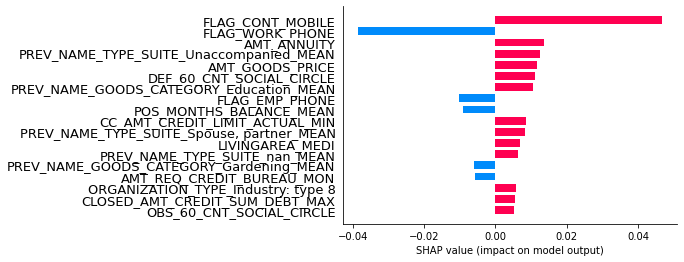

In [48]:
shap.bar_plot(shap_values[sample_idx], max_display=18, feature_names=feature_names)

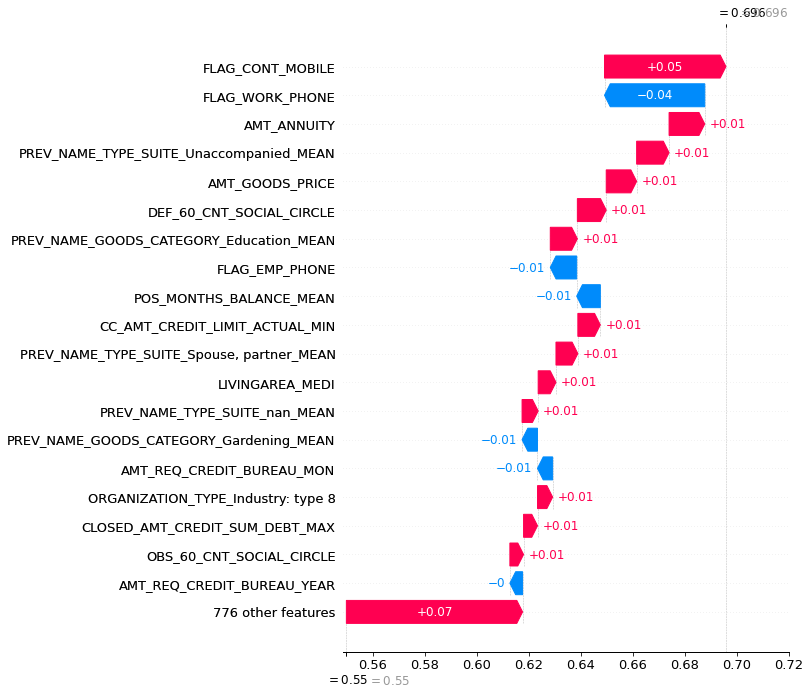

In [49]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[0],
    shap_values[sample_idx],
    max_display=20,
    feature_names=feature_names,
)

In [51]:
shap.force_plot(
    explainer.expected_value[0],
    shap_values[sample_idx],
    feature_names=feature_names,
    out_names="Shap Value",
)

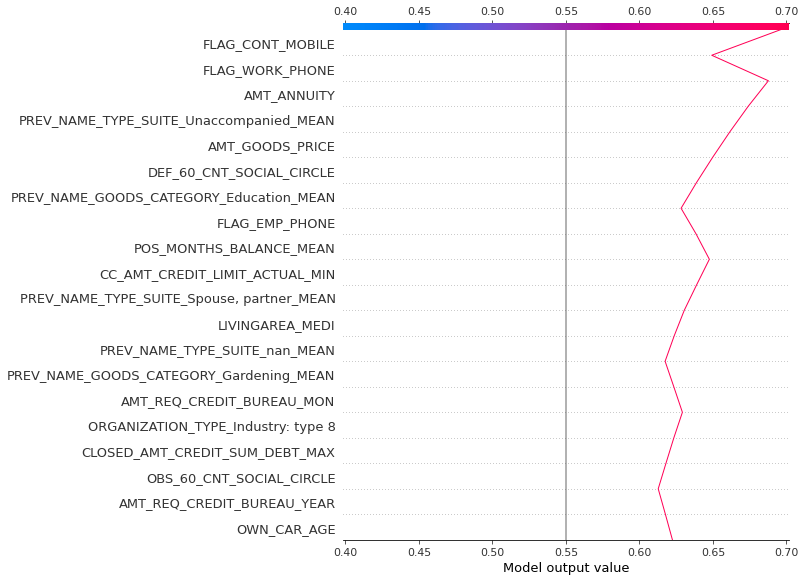

In [52]:
shap.decision_plot(explainer.expected_value[0], shap_values[sample_idx],
                feature_names=list(feature_names))

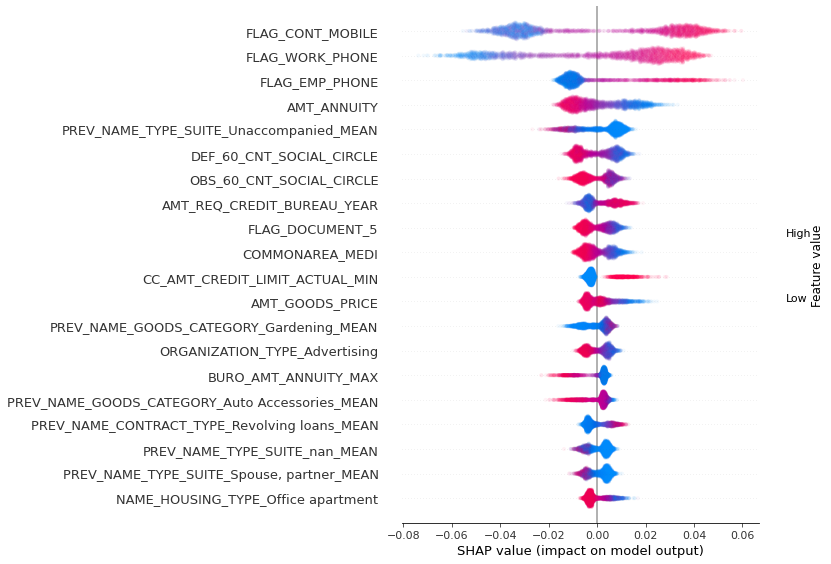

CPU times: user 1.46 s, sys: 824 ms, total: 2.28 s
Wall time: 1.15 s


In [53]:
%%time
shap.summary_plot(
    shap_values, features=X_test_transformed, feature_names=feature_names, alpha=0.05
)

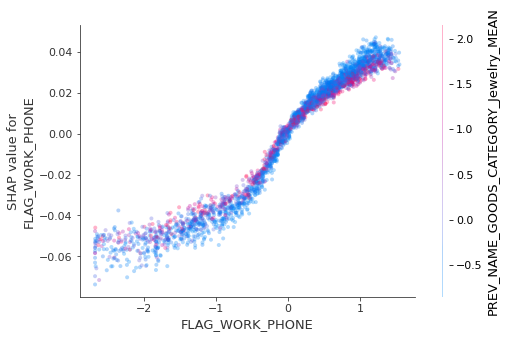

CPU times: user 6.84 s, sys: 190 ms, total: 7.03 s
Wall time: 6.83 s


In [54]:
%%time
shap.dependence_plot(
    importances.index[0],
    shap_values,
    features=X_test_transformed,
    feature_names=feature_names,
    alpha=0.3,
)

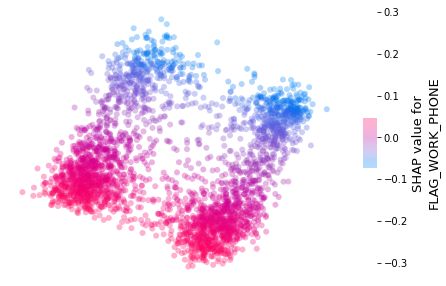

CPU times: user 2.05 s, sys: 2.07 s, total: 4.12 s
Wall time: 629 ms


In [55]:
%%time
shap.embedding_plot(
    importances.index[0],
    shap_values,
    feature_names=feature_names,
    alpha=0.3
)

# Other graphs

In [6]:
%%time
X_test_array = np.load("../data/train/X_test_transformed.npy")
print("X_test_array:", X_test_array.shape)

X_test_array: (3000, 795)
CPU times: user 4.33 ms, sys: 133 ms, total: 138 ms
Wall time: 288 ms


In [8]:
%%time
# import DataFrames
y_test = pd.read_csv("../data/train/y_test.csv")
print("Test dataset:", c.shape)

Test dataset: (101472, 1)
CPU times: user 30.7 ms, sys: 4.66 ms, total: 35.4 ms
Wall time: 41.4 ms


In [23]:
with open("../data/train/columns_list.json", "r") as f:
    columns_test = json.load(f)

In [29]:
X_test_array_with_y = pd.DataFrame(
    data=np.concatenate(
        (X_test_array, np.array(y_test.TARGET[:3000]).reshape(-1, 1)), axis=1
    ),
    columns=columns_test + ["TARGET"],
)
X_test_array_with_y.shape

(3000, 796)

In [31]:
X_test_array_with_y.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT,TARGET
0,0.804197,-0.202576,-0.780837,-0.842968,-0.845795,0.139348,0.878240,0.551118,0.112916,1.969483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.580881,-0.363388,-1.151969,-1.204754,-1.089232,0.126729,0.142963,-2.249635,-0.528736,-0.794467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.580881,0.521078,1.866272,0.635461,2.197173,0.398365,-1.156661,0.847786,1.364976,-1.085235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.580881,-0.282982,-0.369462,-0.283872,-0.237201,-0.991327,-1.035680,0.847786,0.440133,-0.294400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.580881,0.360266,0.189472,2.729980,0.371392,-0.773052,-1.267101,0.847786,-2.368480,-0.599739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
X_test_array_with_y.to_csv("../data/train/test_df.csv")

## Scatter Plot avec 2 Features Choisies

In [339]:
sample_idx = random.randint(0, len(X_test_transformed))

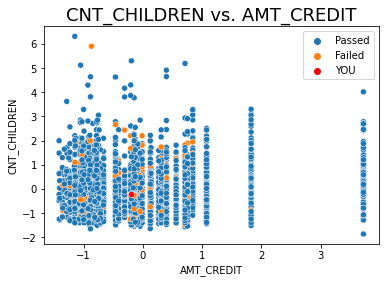

In [124]:
scatter_x = "AMT_CREDIT"
scatter_y = "CNT_CHILDREN"
index = sample_idx
hue = "TARGET"
sns.scatterplot(
    x=scatter_x, y=scatter_y, data=X_test_array_with_y, hue=hue
)
ax = sns.scatterplot(
    x=scatter_x,
    y=scatter_y,
    data=X_test_array_with_y[index:index+1],
    hue=hue,
    palette=["red"],
)
legend_labels, _= ax.get_legend_handles_labels()
plt.title(f"{y} vs. {x}", fontdict={'fontsize': 18})
ax.legend(legend_labels, ['Passed', 'Failed', 'YOU'])#, bbox_to_anchor=(1.26,1))
plt.show()

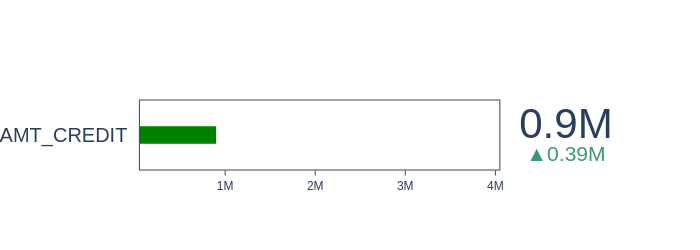

In [213]:
fig = go.Figure(
    go.Indicator(
        mode="number+gauge+delta",
        gauge={
            "shape": "bullet",
            "axis": {
                "range": [X_test_3000.AMT_CREDIT.min(), X_test_3000.AMT_CREDIT.max()]
            },
        },
        value=X_test_3000.AMT_CREDIT[index],
        delta = {'reference': X_test_3000.AMT_CREDIT.median()},
        domain={"x": [0.11, 1], "y": [0, 1]},
        title={"text": "AMT_CREDIT"},
    )
)
fig.update_layout(height=250)

fig.show("png")

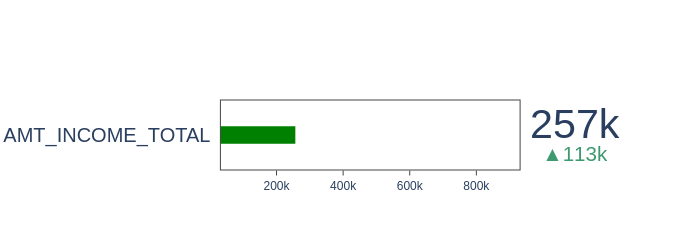

In [219]:
fig = go.Figure(
    go.Indicator(
        mode="number+gauge+delta",
        gauge={
            "shape": "bullet",
            "axis": {
                "range": [X_test_3000.AMT_INCOME_TOTAL.min(), X_test_3000.AMT_INCOME_TOTAL.max()]
            },
        },
        value=X_test_3000.AMT_INCOME_TOTAL[index],
        delta = {'reference': X_test_3000.AMT_INCOME_TOTAL.median()},
        domain={"x": [0.26, 1], "y": [0, 1]},
        title={"text": "AMT_INCOME_TOTAL"},
    )
)
fig.update_layout(height=250)

fig.show("png")